In [2]:
import numpy as np
import pandas as pd
import plotnine as gg

from CurlingDB import CurlingDB
from utils.PlotnineElements import PlotnineElements as pe, blank

In [25]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Things to get
## Plots
- Match summary, plot all of the frames for each end for the whole match
- Stone heatmap
    - Stone heatmap per tournament or per year
- Player accuracy vs number of shots

## Stats
- Player accuracy
- Player accuracy by year, tournament
- Shot type frequency
- Accuracy by shot type
- Shot type frequency by type of shot

## Questions
- Who are the best/most accurate players for certain throws(over 50 or 100) total throws
- 

## Create Database Connection

In [4]:
# db = CurlingDB()
db = CurlingDB(db_name='world_curling.db')

## Curling Dimensions

In [5]:
# All values in m
circles = [0.152, 0.610, 1.219, 1.829]
pixel_to_m = 0.007370759
ice_width = [-4.75/2, 4.75/2]
ice_length = [-2, 6.401]
stone_radius = 14.5

# Circle values
inc = np.pi / 16
circle_range_x = np.cos(np.arange(0, 2 * np.pi + inc, inc))
circle_range_y = np.sin(np.arange(0, 2 * np.pi + inc, inc))

# Some Plots

## Stone Position Testing

### Query

In [127]:
stone_position_cmd = """
SELECT x, y, colour, frame_num, m.type
FROM Stone s
JOIN Position p
  ON s.position_id = p.position_id
JOIN End e
  ON p.end_id = e.end_id
JOIN Match m
  ON e.match_id = m.match_id
"""
db.execute_query(stone_position_cmd)
all_stone_positions = pd.DataFrame(db.cursor.fetchall(), columns=['x', 'y', 'colour', 'frame_num', 'match_type'])
print(all_stone_positions.shape)
all_stone_positions.head()

(1056009, 5)


,x,y,colour,frame_num,match_type
0,-0.556492,1.245658,yellow,1,Womens_Teams
1,1.241973,3.877019,red,2,Womens_Teams
2,-0.556492,1.253029,yellow,2,Womens_Teams
3,1.238288,3.891761,red,3,Womens_Teams
4,-0.287460,-0.493841,yellow,3,Womens_Teams


### Filter out the top n most common

In [128]:
top_offenders = all_stone_positions[['x', 'y']].value_counts()[:6]
top_x = top_offenders.index.get_level_values(0)
top_y = top_offenders.index.get_level_values(1)
limited_stones = all_stone_positions.loc[(all_stone_positions.apply(lambda c: c['x'] not in top_x, axis=1) & (all_stone_positions.apply(lambda c: c['y'] not in top_y, axis=1)))]

### Create heatmap

#### Women's Heatmap

In [168]:
def stone_heatmap(df, match_type: str=None, size=5):

     if match_type is not None:
          plot_df = df.query('match_type == @match_type')
     else:
          plot_df = df
     
     return (gg.ggplot(plot_df, gg.aes(x='x', y='y'))
          + gg.geom_bin_2d()
          + gg.facet_grid('. ~ frame_num')
          + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y, colour='white', size=1.25)
          + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y, colour='white', size=1.25)
          + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y, colour='white', size=1.25)
          + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y, colour='white', size=1.25)

          + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
          + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
          # + gg.scale_fill_gradientn(colors=['#000000', '#ff4f00', '#E41C16'], values=[0, 0.3, 1], guide=False)
          + gg.scale_fill_gradientn(colors=['#000000', '#ff4f00', '#ffD000'], values=[0, 0.3, 1], guide=False)

          + gg.theme(text=gg.element_text(colour='#ffffff'))
          + gg.theme(axis_text=blank)
          + gg.theme(axis_title=blank)
          + gg.theme(figure_size=(size * (plot_df.frame_num.max() + 1 if match_type == 'Mixed_Doubles' else plot_df.frame_num.max()), size * ((800 + 300)/(600))))

          + pe.background_colour(colour='black', plot_colour='black')
          + pe.remove_ticks(minor=True)
          )


/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bin_2d : Removed 227 rows containing missing values.


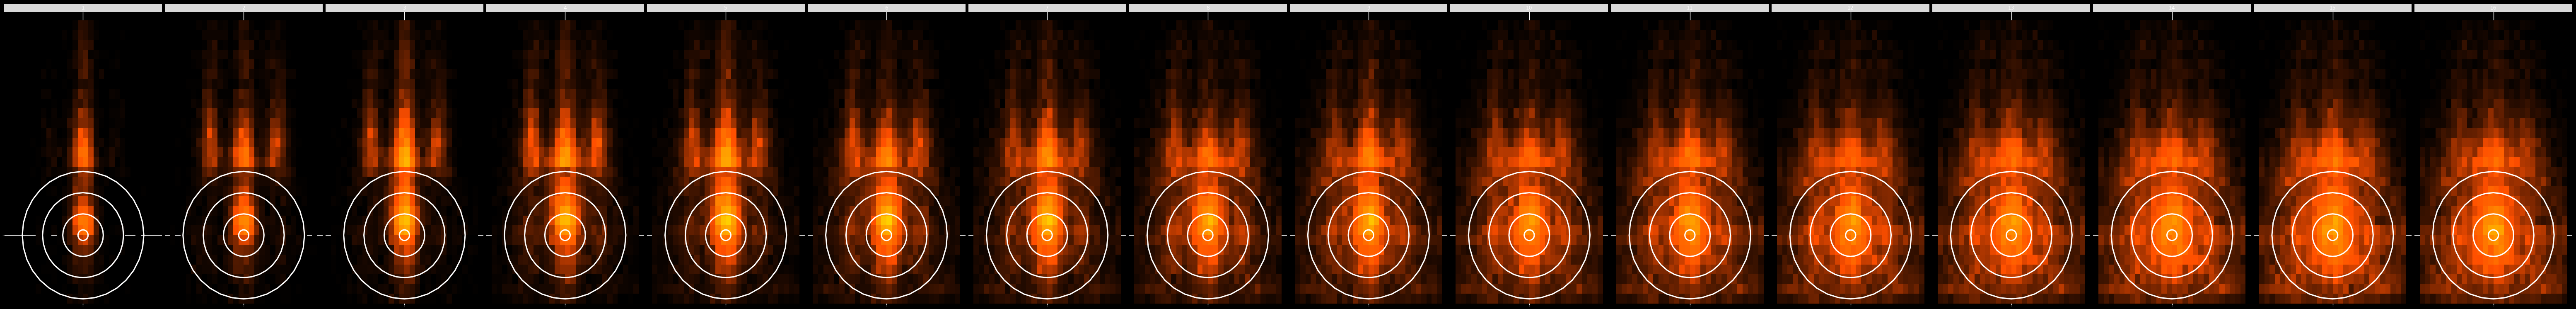

<ggplot: (929261201)>

In [169]:
stone_heatmap(limited_stones, match_type='Womens_Teams')

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bin_2d : Removed 190 rows containing missing values.


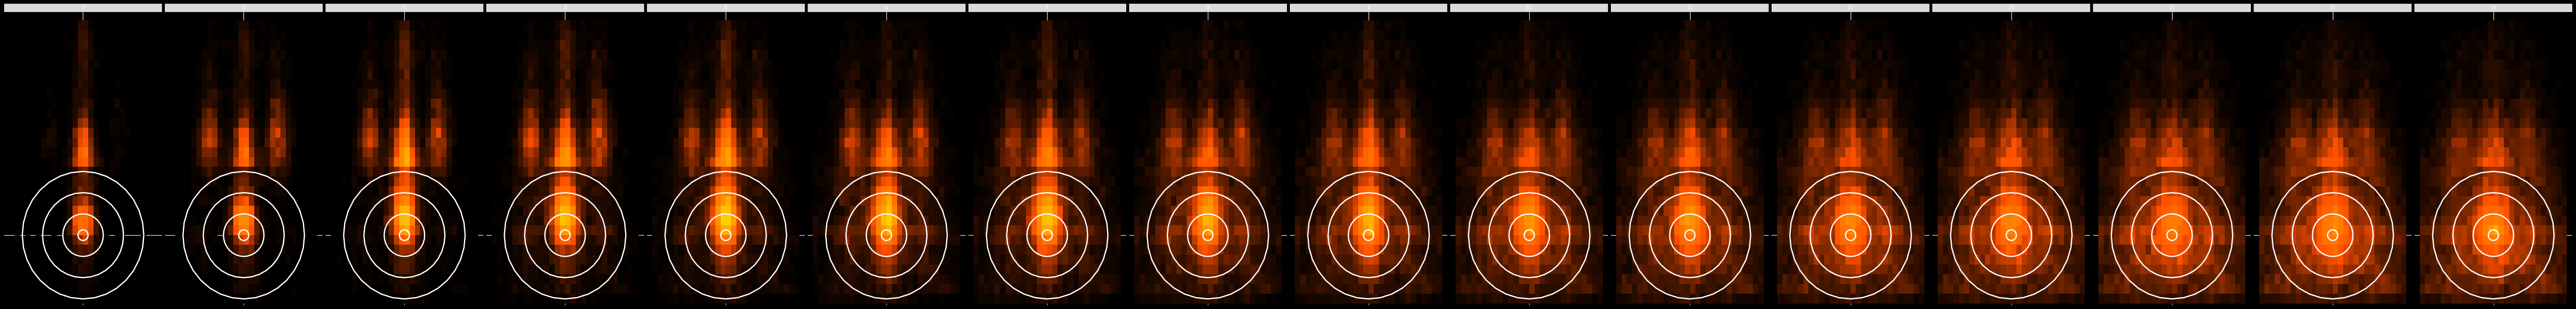

<ggplot: (953633521)>

In [170]:
stone_heatmap(limited_stones, match_type='Mens_Teams')

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bin_2d : Removed 113 rows containing missing values.


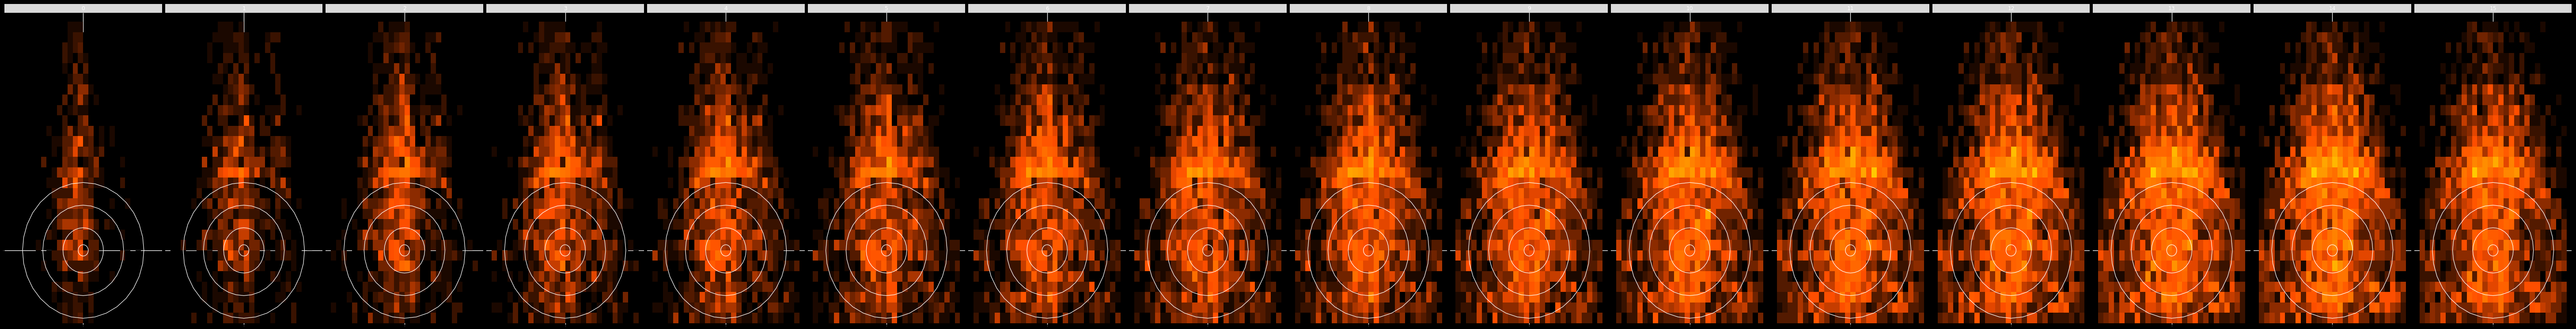

<ggplot: (960306038)>

In [151]:
stone_heatmap(limited_stones, match_type='Mixed_Teams')

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bin_2d : Removed 88 rows containing missing values.


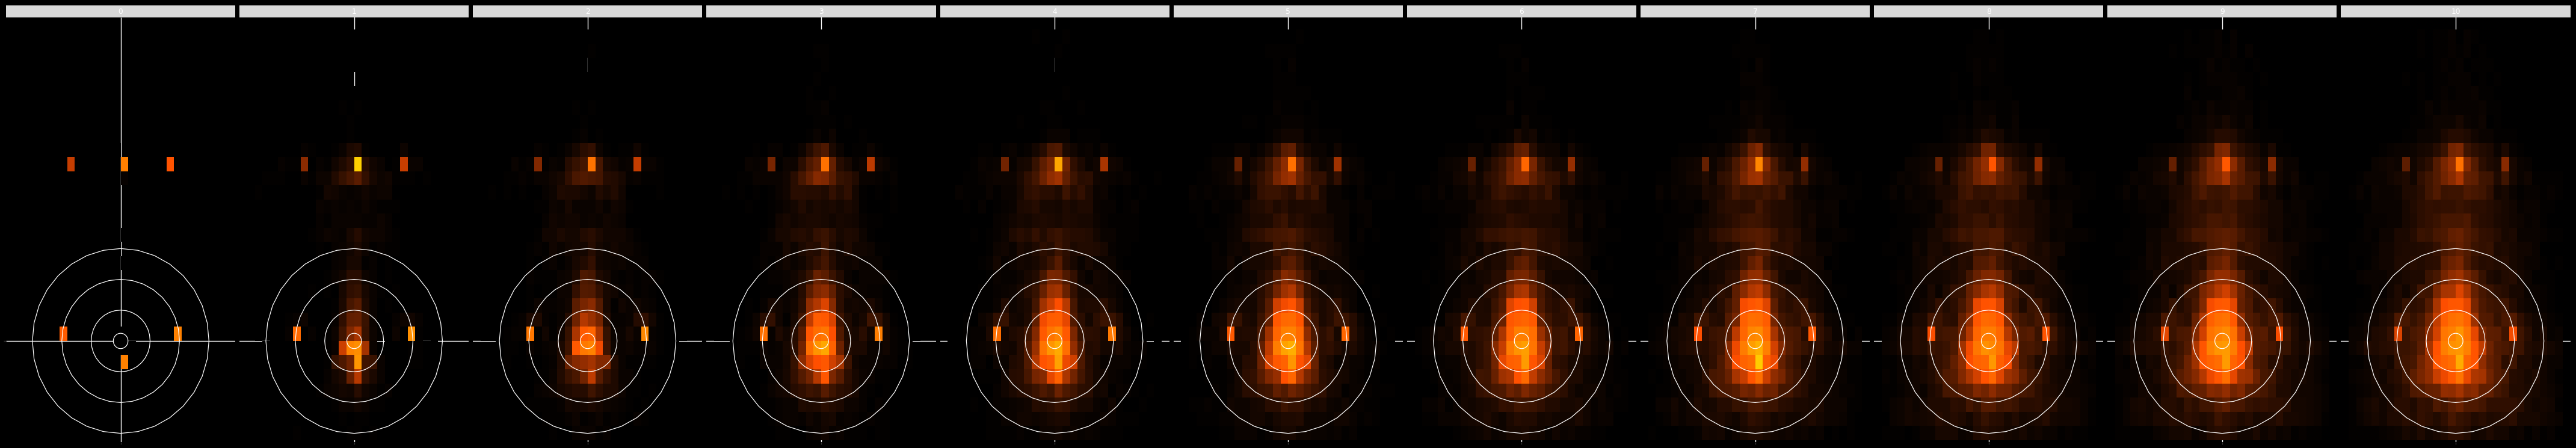

<ggplot: (941483695)>

In [158]:
stone_heatmap(limited_stones, match_type='Mixed_Doubles')

## Match Summary
- TODO: Could introduce another query to get match specific, end specific, and frame/throw specific information
    - Include accuracy per team per end
    - Include type of throw per frame
    - Include player
    - Include current score


### Query

In [14]:
match_summary_cmd = """
SELECT m.team_1, m.team_2, e.num, e.hammer_colour, e.direction, p.frame_num, s.x, s.y, s.colour
FROM Stone s
RIGHT JOIN Position p
ON s.position_id = p.position_id
JOIN End e
ON p.end_id = e.end_id
JOIN Match m
ON e.match_id = m.match_id
WHERE m.match_id = ?
"""
db.execute_query(match_summary_cmd, (485,))
match_summary = pd.DataFrame(db.cursor.fetchall(), columns=['team_1', 'team_2', 'end_num', 'hammer_colour', 'play_direction', 'frame_num', 'x', 'y', 'colour'])
print(match_summary.shape)
match_summary.head()

(434, 9)


,team_1,team_2,end_num,hammer_colour,play_direction,frame_num,x,y,colour
0,OAR,NOR,1,yellow,down,0,0.003685,3.324212,red
1,OAR,NOR,1,yellow,down,0,0.003685,-0.464358,yellow
2,OAR,NOR,1,yellow,down,1,-0.103191,0.398021,red
3,OAR,NOR,1,yellow,down,1,0.007371,3.324212,red
4,OAR,NOR,1,yellow,down,1,0.007371,-0.464358,yellow


### Plot

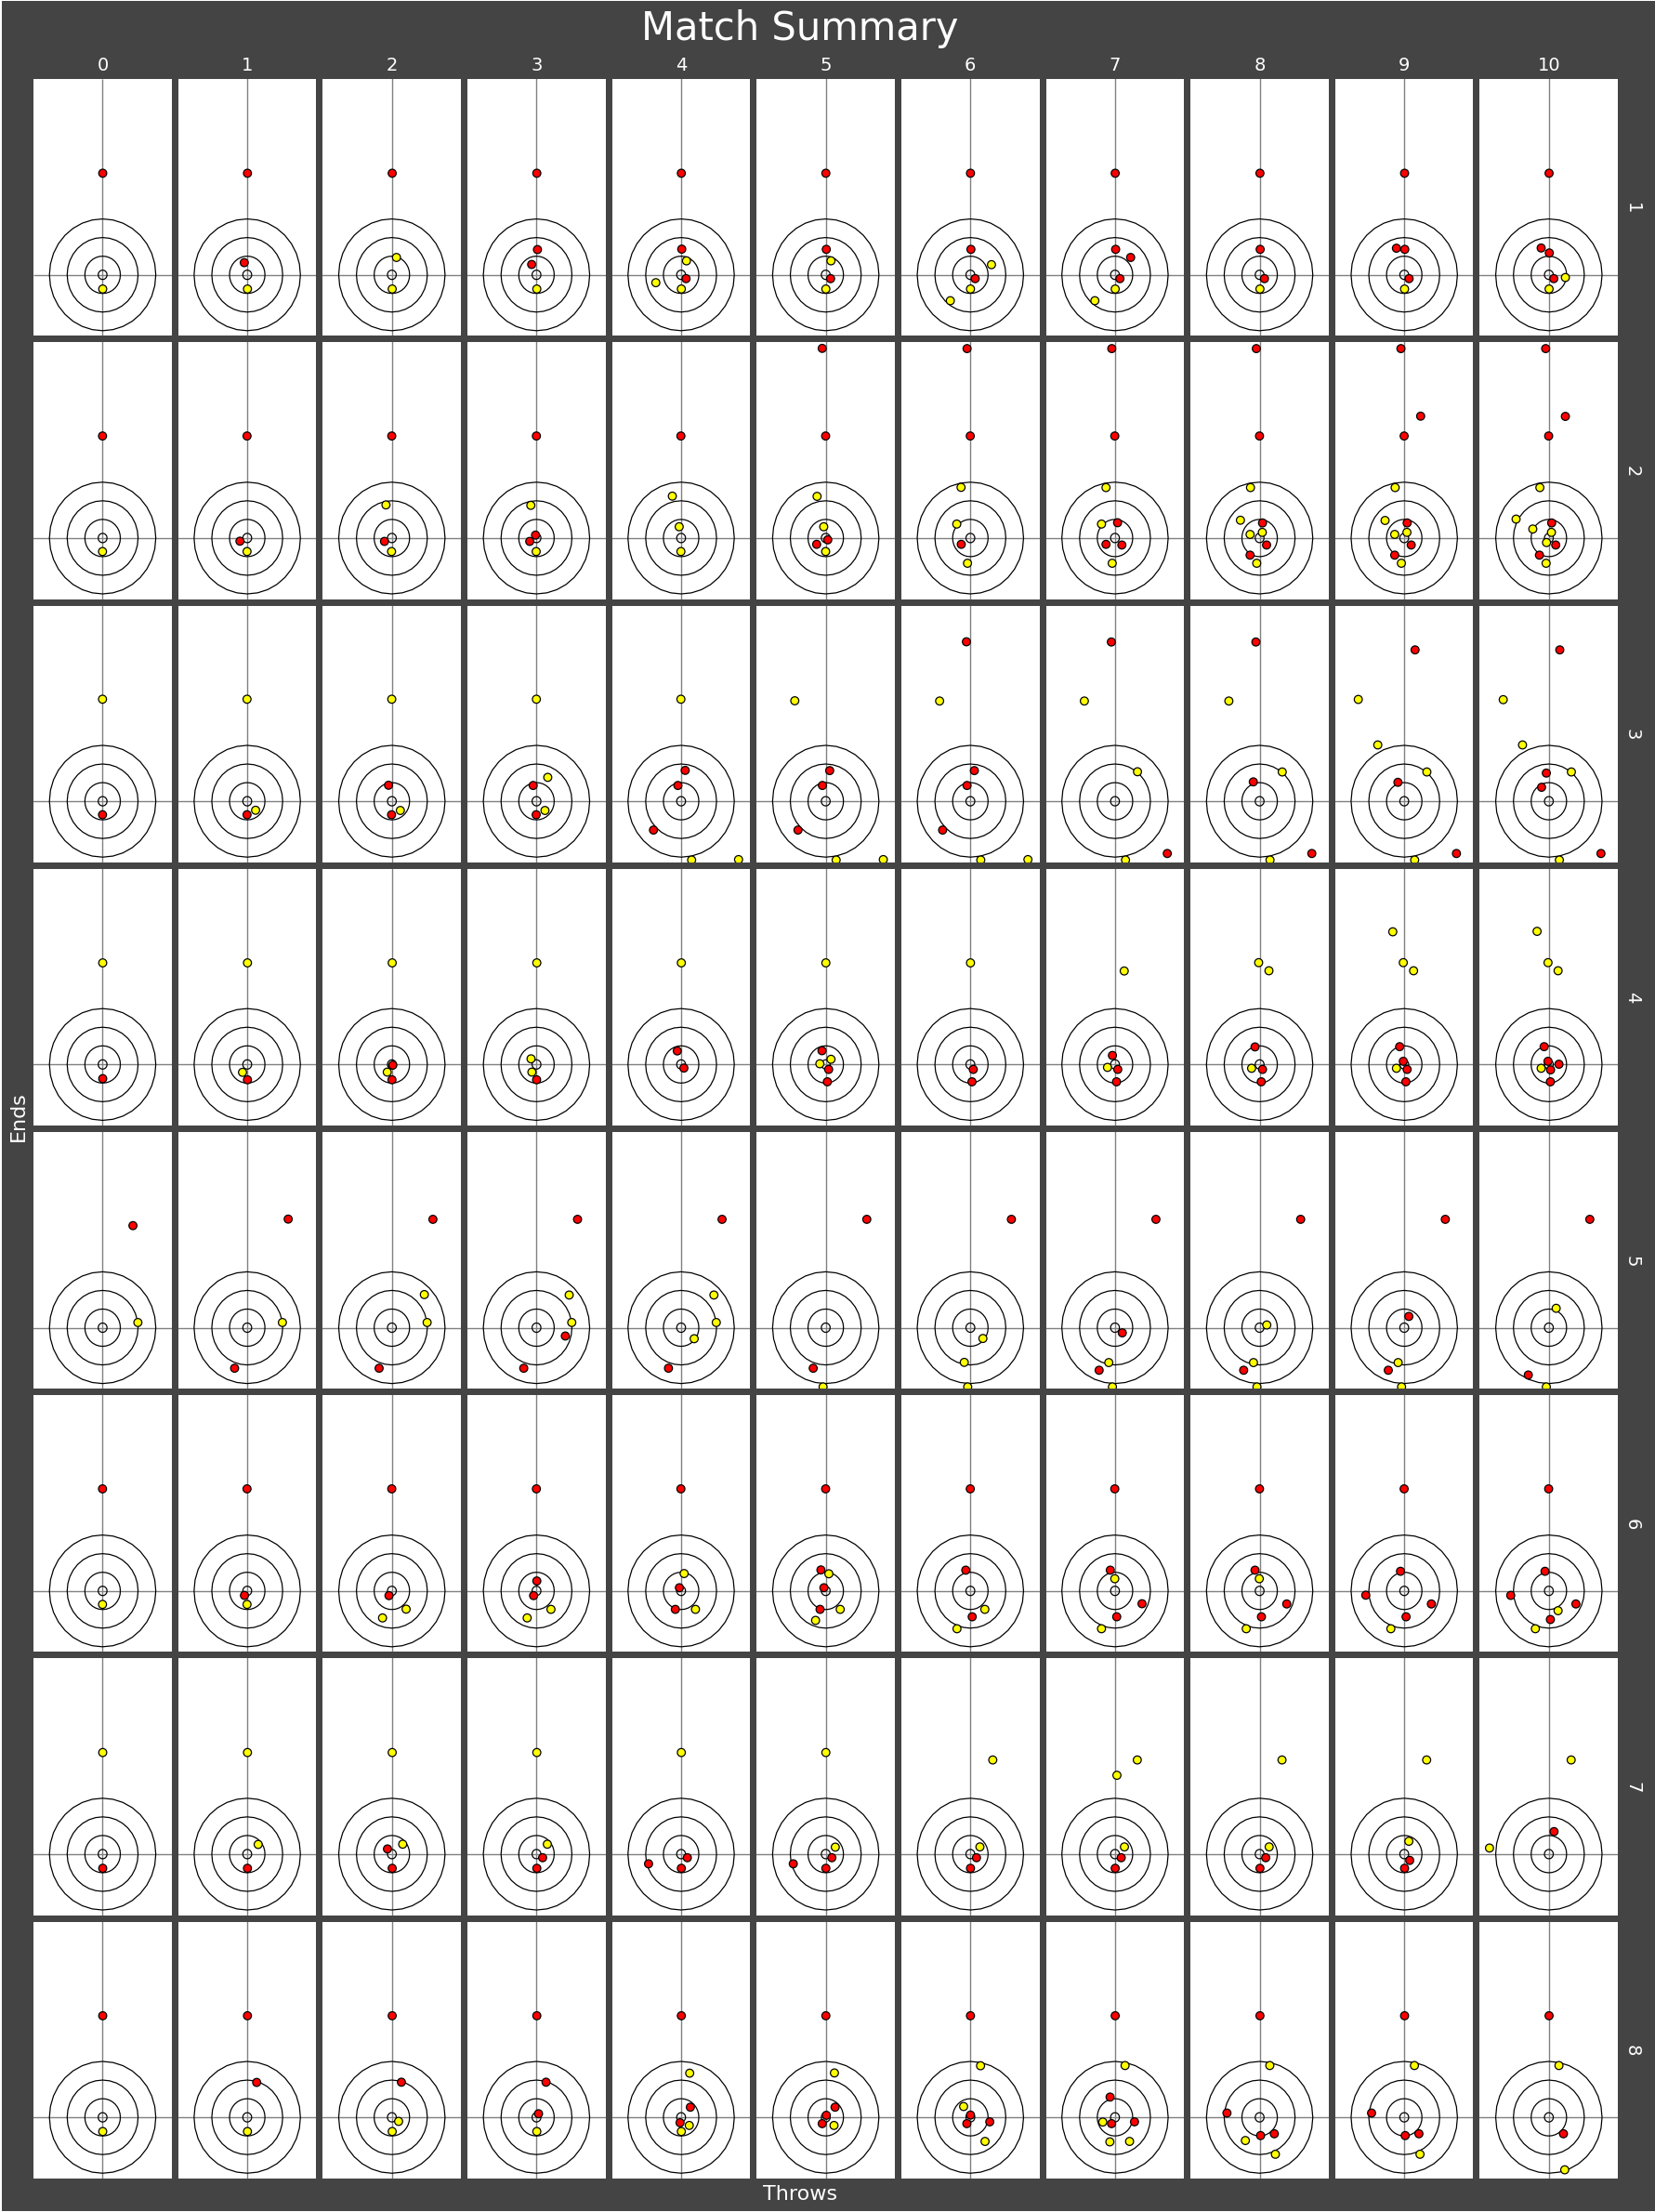

<ggplot: (953208796)>

In [175]:
size = 2
(gg.ggplot(match_summary, gg.aes(x='x', y='y', fill='colour'))
    + gg.annotate(geom='path', x=circles[0] * circle_range_x, y=circles[0] * circle_range_y)
    + gg.annotate(geom='path', x=circles[1] * circle_range_x, y=circles[1] * circle_range_y)
    + gg.annotate(geom='path', x=circles[2] * circle_range_x, y=circles[2] * circle_range_y)
    + gg.annotate(geom='path', x=circles[3] * circle_range_x, y=circles[3] * circle_range_y)
    + gg.geom_point(size=3)

    + gg.facet_grid('end_num ~ frame_num', space='free')

    + gg.scale_x_continuous(limits=ice_width, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_y_continuous(limits=ice_length, expand=(0, 0), breaks=lambda x: [0])
    + gg.scale_fill_manual(values=['red', 'yellow'], guide=False)
    + gg.theme(figure_size=(size * (match_summary['frame_num'].max() + 1), size * (match_summary['end_num'].max()) * ((800 + 300)/(600))))
    + gg.theme(panel_grid=gg.element_line(colour='gray'))
    + gg.theme(text=gg.element_text(colour='white'))
    + gg.theme(axis_text=blank)
    + gg.theme(strip_text=gg.element_text(size=14), strip_background=blank)

    + pe.background_colour(panel_colour='#FFFFFF', plot_colour='#444444')
    + pe.remove_grid(minor=True)
    + pe.remove_ticks(minor=True, major=True)
    + pe.labels(title='Match Summary', x='Throws', y='Ends', title_size=30, x_size=16, y_size=16)
 )

## Linking Throws and Positions for Rating per Throw Type

### Query

In [100]:
# Get each throw along with the count of stones
linking_cmd = """
SELECT frames.position_id, frames.type, frames.num, frames.frame_num, frames.coun, throws.colour, throws.name, throws.team, throws.sex, throws.type, throws.rating
FROM
(SELECT p.frame_num, 
        e1.num,
        p.position_id,
        e1.end_id,
        m1.type,
        COUNT(*) as coun
FROM Stone s
JOIN Position p
  ON s.position_id = p.position_id
JOIN End e1
  ON p.end_id = e1.end_id
JOIN Match m1
  ON e1.match_id = m1.match_id
JOIN Event e2
  ON m1.event_id = e2.event_id
GROUP BY 3
) frames
LEFT JOIN
(SELECT t.throw_num, 
        t.colour, 
        p.name, 
        p.team, 
        p.sex,
        t.type, 
        t.rating, 
        e1.num,
        e1.end_id
FROM Throw t
JOIN Player p
  ON t.player_id = p.player_id
JOIN End e1
  ON t.end_id = e1.end_id
JOIN Match m1
  ON e1.match_id = m1.match_id
JOIN Event e2
  ON m1.event_id = e2.event_id
) throws
  ON frames.frame_num = throws.throw_num AND frames.end_id = throws.end_id

"""
db.execute_query(linking_cmd)
# linking = pd.DataFrame(db.cursor.fetchall(), columns=['team_1', 'team_2', 'end_num', 'hammer_colour', 'play_direction', 'frame_num', 'rating', 'x', 'y', 'colour'])
linking = pd.DataFrame(db.cursor.fetchall(), columns=['position_id', 'match_type', 'end_num', 'throw_num', 'stone_count', 'colour', 'name', 'team', 'sex', 'type', 'rating'])
print(linking.shape)
linking.head()

(255246, 11)


,position_id,match_type,end_num,throw_num,stone_count,colour,name,team,sex,type,rating
0,2,Womens_Teams,1,1,1,yellow,FREDERICKS ARMSTR.,AUS,f,Draw,0.0
1,3,Womens_Teams,1,2,2,red,THOMPSON H,NZL,f,Front,2.0
2,4,Womens_Teams,1,3,3,yellow,FREDERICKS ARMSTR.,AUS,f,Draw,3.0
3,5,Womens_Teams,1,4,3,red,THOMPSON H,NZL,f,Draw,4.0
4,6,Womens_Teams,1,5,5,yellow,POWELL A,AUS,f,Take-out,2.0


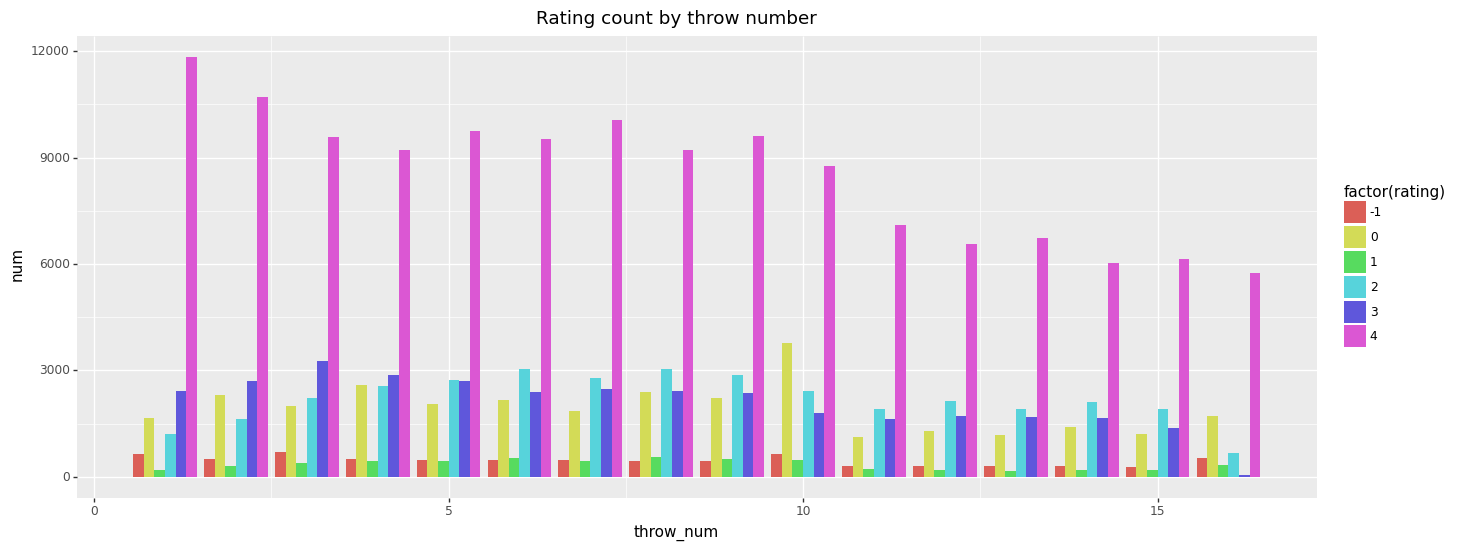

<ggplot: (711755942)>

In [104]:
(gg.ggplot(pd.DataFrame(linking[['throw_num', 'rating']].value_counts().sort_index()).reset_index().rename(columns={0:'num'}), gg.aes(x='throw_num', y='num', fill='factor(rating)')) 
    + gg.geom_col(position='dodge') 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Rating count by throw number'))

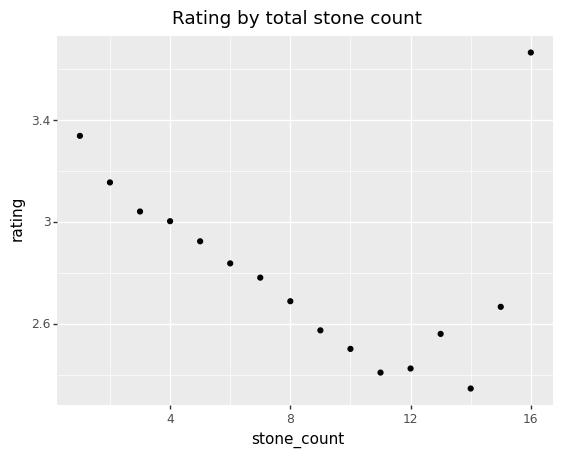

<ggplot: (934762593)>

In [126]:
(gg.ggplot(linking.query('rating != -1').groupby(['stone_count']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='stone_count', y='rating')) 
    + gg.geom_point() 
    + pe.labels(title='Rating by total stone count'))

In [98]:
linking.query('rating != -1').groupby(['sex']).agg({'rating': 'mean'}).reset_index()

,sex,rating
0,f,3.052543
1,m,3.195694
2,u,2.458963


In [102]:
linking.query('rating != -1').groupby(['match_type', 'sex']).agg({'rating': 'mean'}).reset_index()

,match_type,sex,rating
0,Mens_Teams,f,3.247126
1,Mens_Teams,m,3.238464
2,Mixed_Doubles,f,2.742204
3,Mixed_Doubles,m,2.859135
4,Mixed_Doubles,u,2.477466
5,Mixed_Teams,f,2.780105
6,Mixed_Teams,m,2.235294
7,Mixed_Teams,u,2.407580
8,Womens_Teams,f,3.081059
9,Womens_Teams,m,3.085034


/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


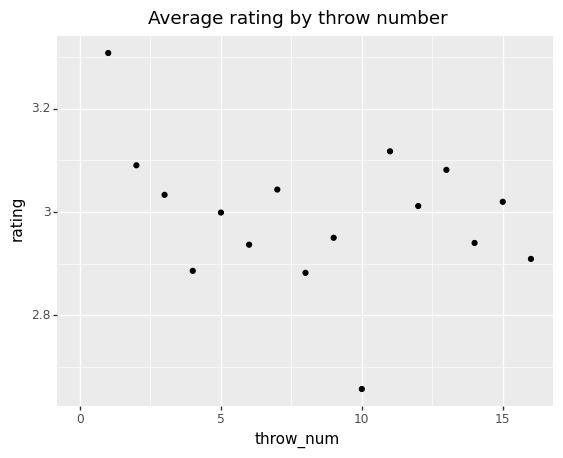

<ggplot: (910718537)>

In [106]:
(gg.ggplot(linking.query('rating != -1').groupby(['throw_num']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='throw_num', y='rating')) 
    + gg.geom_point() 
    + pe.labels(title='Average rating by throw number'))

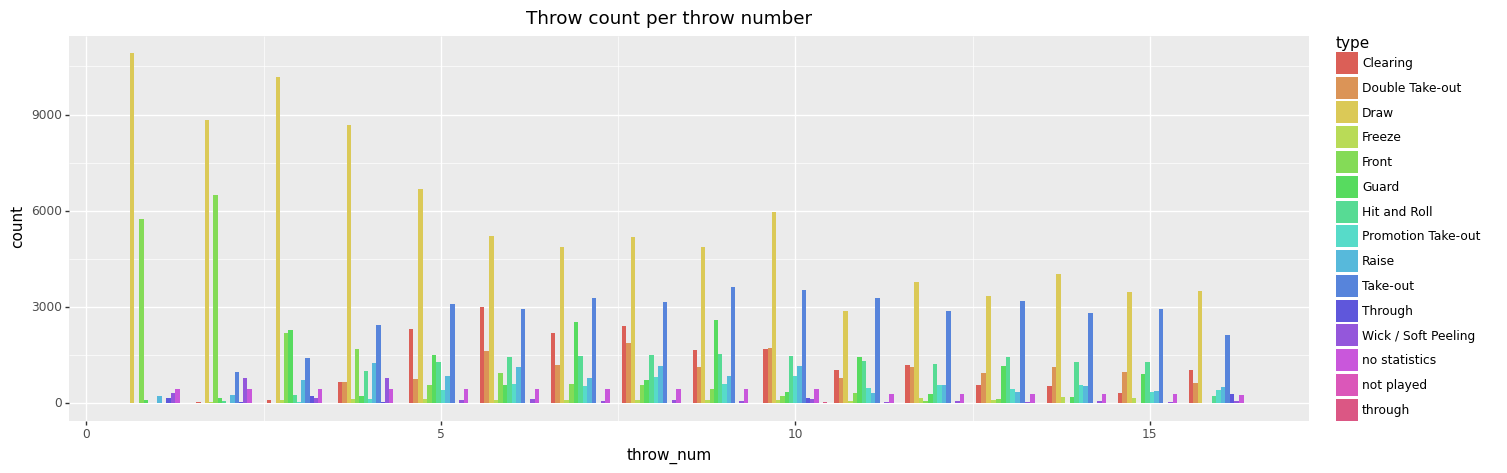

<ggplot: (710831915)>

In [115]:
# Throw count for the given throw count or number of stones
(gg.ggplot(linking.dropna(), gg.aes(x='throw_num', fill='type')) 
     + gg.geom_bar(position='dodge') 
     + gg.theme(figure_size=(16, 5)) 
     + pe.labels(title='Throw count per throw number'))

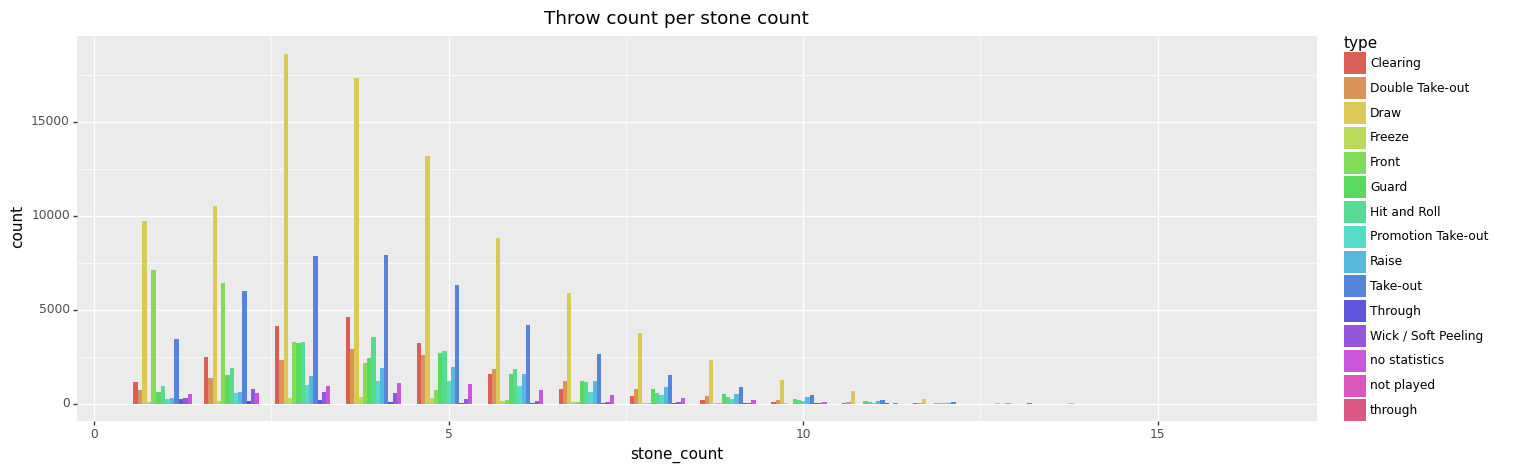

<ggplot: (928825775)>

In [116]:
(gg.ggplot(linking.dropna(), gg.aes(x='stone_count', fill='type')) 
    + gg.geom_bar(position='dodge') 
    + gg.theme(figure_size=(16, 5)) 
    + pe.labels(title='Throw count per stone count'))

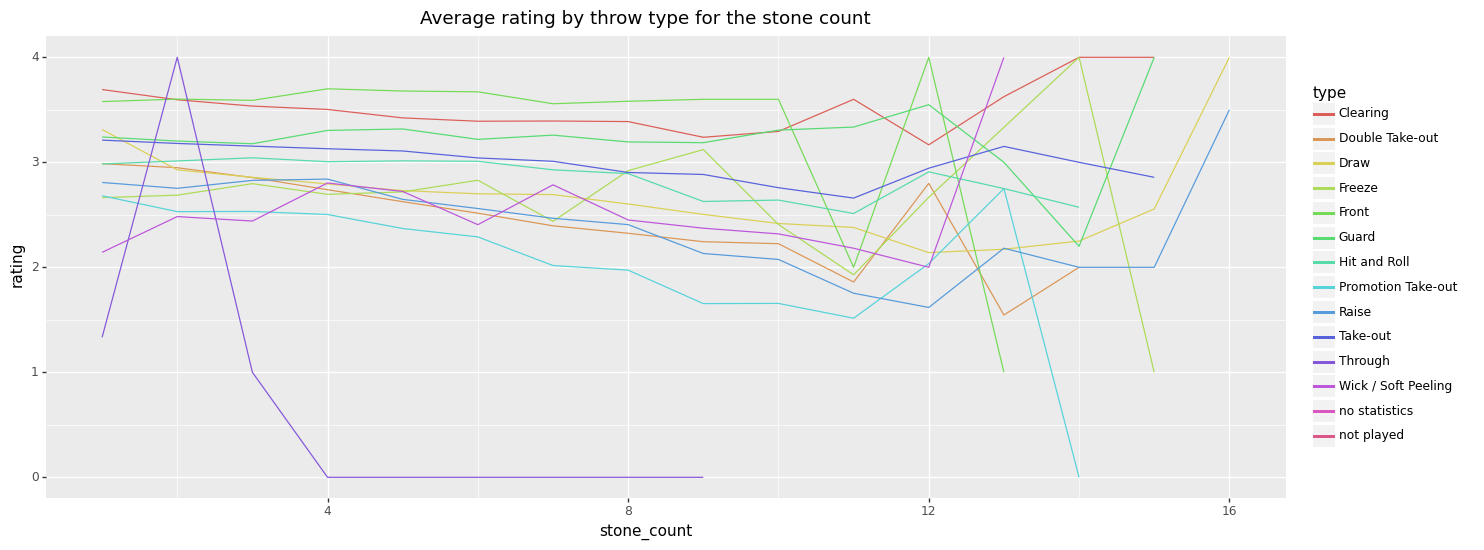

<ggplot: (707882978)>

In [107]:
(gg.ggplot(linking.query('rating != -1').groupby(['type', 'stone_count']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='stone_count', y='rating', colour='type')) 
    + gg.geom_line() 
    + gg.theme(figure_size=(16, 6)) 
    + pe.labels(title='Average rating by throw type for the stone count'))

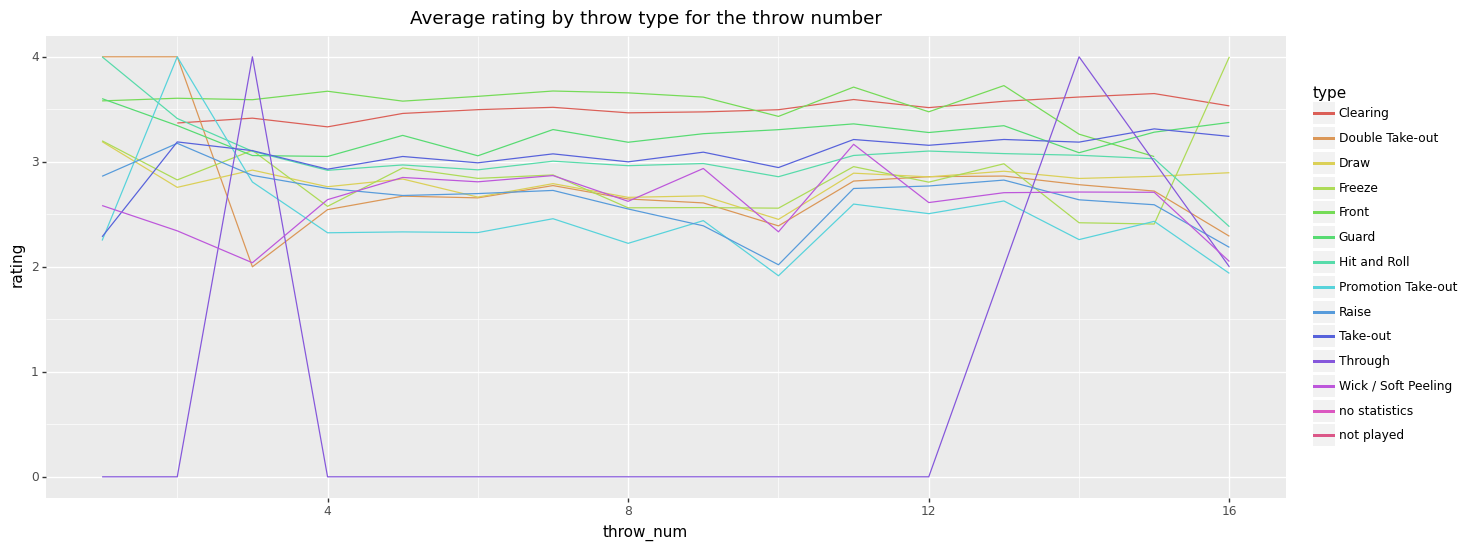

<ggplot: (708049610)>

In [108]:
(gg.ggplot(linking.query('rating != -1').groupby(['type', 'throw_num']).agg({'rating': 'mean'}).reset_index(), gg.aes(x='throw_num', y='rating', colour='type')) 
    + gg.geom_line() 
    + gg.theme(figure_size=(16, 6))
    + pe.labels(title='Average rating by throw type for the throw number'))

## Player Accuracy

In [176]:
player_cmd = """
SELECT p.name, p.team, p.sex, t.throw_num, t.rating
FROM Throw t
JOIN Player p
  ON t.player_id = p.player_id
"""
db.execute_query(player_cmd)
players = pd.DataFrame(db.cursor.fetchall(), columns=['name', 'team', 'sex', 'throw_num', 'rating'])
print(players.shape)
players.head()

(255097, 5)


,name,team,sex,throw_num,rating
0,FREDERICKS ARMSTR.,AUS,f,1,0.0
1,THOMPSON H,NZL,f,2,2.0
2,FREDERICKS ARMSTR.,AUS,f,3,3.0
3,THOMPSON H,NZL,f,4,4.0
4,POWELL A,AUS,f,5,2.0


In [201]:
player_ratings = players.groupby(['name', 'team', 'sex']).agg({'rating':[('mean', 'mean'), ('count', 'count')]})
player_ratings.columns = ['_'.join(col) for col in player_ratings.columns.values]
player_ratings = player_ratings.dropna().reset_index()
player_ratings.sort_values('name')

,name,team,sex,rating_mean,rating_count
0,ABBES E,GER,f,2.971306,697
1,ABE S,JPN,m,3.350932,322
2,ADAMS V,GBR,f,3.138889,216
3,ADAMS V,SCO,f,3.283019,742
4,ADVIENTO E,NZL,u,2.141509,106
...,...,...,...,...,...
957,ZHOU Y,CHN,f,3.131783,516
958,ZHUZBAY A,KAZ,m,2.686316,475
959,ZIOLO T,POL,m,2.000000,14
960,ZOU D,CHN,m,3.000000,431


In [179]:
player_ratings.sort_values(by=('rating_count'), ascending=False).head(20)

,,rating_mean,rating_count
name,team,,
ERIKSSON O,SWE,3.172936,2047
HASSELBORG A,SWE,3.052023,1903
NEDREGOTTEN M,NOR,3.137728,1866
SUNDGREN C,SWE,3.163231,1795
MABERGS S,SWE,3.096251,1787
EDIN N,SWE,3.102740,1752
McMANUS S,SWE,3.090389,1748
KNOCHENHAUER A,SWE,3.227538,1714
KIM S,KOR,2.928934,1576


/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 20 rows containing missing values.


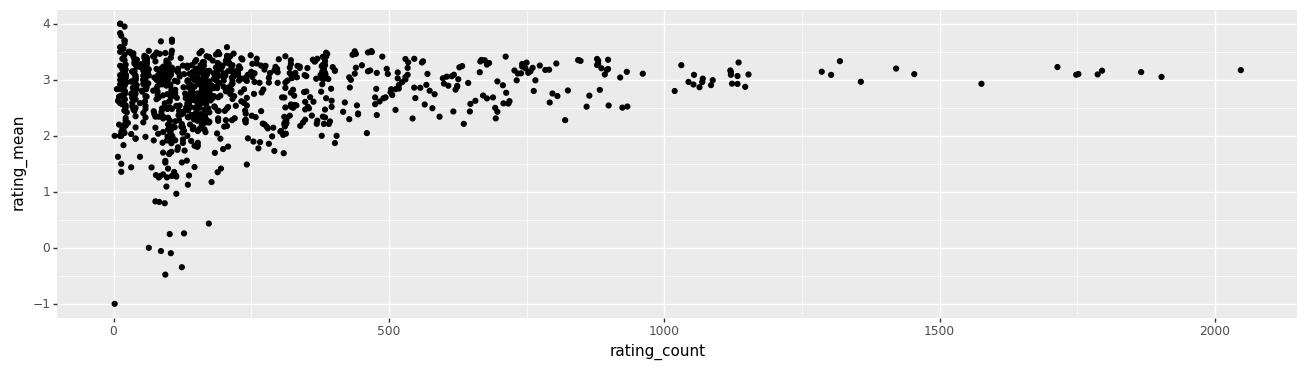

<ggplot: (732105304)>

In [ ]:
gg.ggplot(player_ratings, gg.aes(x='rating_count', y='rating_mean')) + gg.geom_point() + gg.theme(figure_size=(16, 4))